In [ ]:
# from google.colab import files
# import io

# uploaded = files.upload()

Saving mymoviedb.csv to mymoviedb (1).csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [4]:
movies = pd.read_csv("mymoviedb.csv", lineterminator="\n")
# movies = pd.read_csv(io.StringIO(uploaded["mymoviedb.csv"].decode("utf-8")), lineterminator="\n")
movies.drop(movies[movies["Vote_Count"] == 0].index,
            inplace=True)  # usun filmy z przyszlosci
movies.drop(["Overview", "Popularity", "Vote_Count",
            "Poster_Url"], axis=1, inplace=True)

X = movies.drop("Vote_Average", axis=1)
y = movies["Vote_Average"]


In [5]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)
kFold = KFold(n_splits=5)


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]


In [7]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)


In [8]:
from sklearn.preprocessing import OneHotEncoder

simple_cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Original_Language"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

simple_cat_pipeline.fit_transform(X_train)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
from datetime import datetime


class DateEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        cols = []
        for col_name in X.columns:
            cols.append(X[col_name].map(
                lambda x: datetime.strptime(x, "%Y-%m-%d").year))
            cols.append(X[col_name].map(
                lambda x: datetime.strptime(x, "%Y-%m-%d").month))
        return np.c_[cols].T


In [10]:
date_pipeline = Pipeline([
    ("select_date", DataFrameSelector(["Release_Date"])),
    ("imputer", MostFrequentImputer()),
    ("date_encoder", DateEncoder()),
])

date_pipeline.fit_transform(X_train)


array([[2015,    1],
       [2005,    9],
       [1992,    4],
       ...,
       [1983,    7],
       [2015,    7],
       [2007,    3]], dtype=int64)

In [11]:
class GenreEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, delimeter=","):
        self.genres = {}
        for col in X.columns:
            self.genres[col] = set()
            for index, row in X.iterrows():
                self.genres[col] |= set(
                    map(lambda x: x.strip(), row[col].split(delimeter)))
        return self

    def transform(self, X, y=None):
        encoded = []
        returned = []
        for col, curr_genres in self.genres.items():
            for genre in curr_genres:
                encoded.append(X[col].str.contains(genre).astype(int))
            returned.append(pd.DataFrame(data=np.c_[encoded].T, columns=self.genres[col]))
        return pd.concat(returned, axis=1)


In [12]:
genre_pipeline = Pipeline([
    ("select_genre", DataFrameSelector(["Genre"])),
    ("imputer", MostFrequentImputer()),
    ("genre_encoder", GenreEncoder()),
])

genre_pipeline.fit_transform(X_train)

,Crime,Music,History,Science Fiction,TV Movie,Fantasy,Mystery,Adventure,Thriller,Family,Comedy,Romance,War,Action,Horror,Animation,Drama,Documentary,Western
0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8749,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
8750,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
8751,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
8752,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0


In [40]:
import re
from itertools import chain

class TitleEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.genres = {}
        return self

    def transform(self, X, y=None):
        encoded = []
        returned = []
        for col in X.columns:
            encoded.append(X[col].map(lambda x: bool(re.search(r'\d', x))).astype(int))  # cyfry w tytule
            encoded.append(X[col].map(lambda x: len(x.split()))) # ilosc slow w tytule
            encoded.append(X[col].str.contains(":").astype(int))  # dwukropek w tytule
            encoded.append(X[col].str.contains("-").astype(int))  # pauza w tytule
            returned.append(pd.DataFrame(data=np.c_[encoded].T, columns=[f"{col}_Numbers", f"{col}_Len", f"{col}_Colon", f"{col}_Dash"]))

        return pd.concat(returned, axis=1)


In [43]:
title_pipeline = Pipeline([
    ("select_title", DataFrameSelector(["Title"])),
    ("imputer", MostFrequentImputer()),
    ("title_encoder", TitleEncoder()),
])

title_pipeline.fit_transform(X_train)

,Title_Numbers,Title_Len,Title_Colon,Title_Dash
0,0,2,0,0
1,0,4,0,0
2,0,1,0,0
3,0,3,0,0
4,0,6,1,0
...,...,...,...,...
8749,0,2,0,0
8750,0,2,0,0
8751,0,3,0,0
8752,0,5,1,0


In [44]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("simple_cat_pipeline", simple_cat_pipeline),
    ("date_pipeline", date_pipeline),
    ("genre_pipeline", genre_pipeline),
    ("title_pipeline", title_pipeline),
])


In [45]:
print(preprocess_pipeline.transform(X_train).shape)
print(preprocess_pipeline.transform(X_train))

(8754, 66)
[[0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 3. 0. 0.]
 [0. 0. 0. ... 5. 1. 0.]
 [0. 0. 0. ... 5. 1. 0.]]


**Wizualizacja danych**

1. Ilość wystąpień poszczególnych gatunków

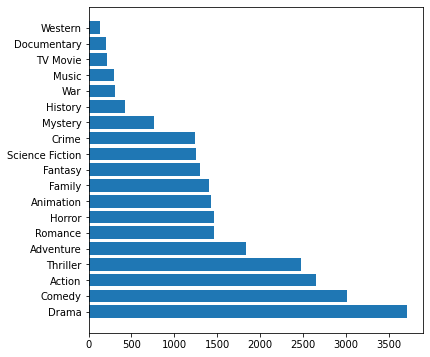

In [24]:
genres_data = genre_pipeline.transform(movies).sum().to_frame().sort_values(0, ascending=False).transpose()

plt.figure(figsize=(6,6))
plt.barh(y=genres_data.columns, width=genres_data.iloc[0])

plt.show()

2. Ilość filmów w (oryginalnie) poszczególnych językach

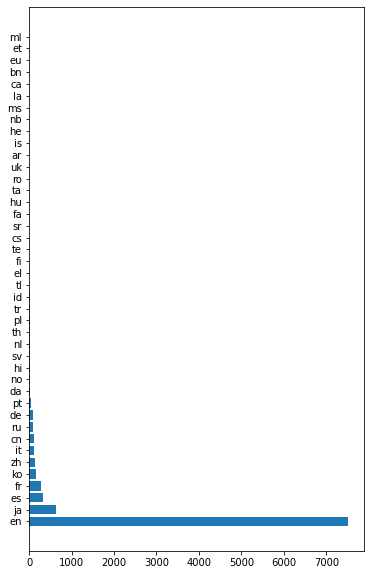

In [27]:
lang_data = pd.get_dummies(movies["Original_Language"]).sum().to_frame().sort_values(0, ascending=False).transpose()

plt.figure(figsize=(6,10))
plt.barh(lang_data.columns, lang_data.iloc[0])

plt.show()

3. Średnie oceny filmów

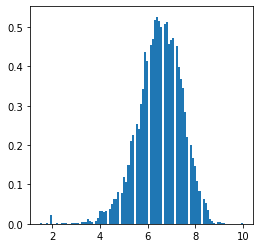

In [46]:
avg_votes = movies["Vote_Average"]

plt.figure(figsize=(4,4))
plt.hist(avg_votes, bins=100, density=True)

plt.show()

4. Rozkład długości tytułów filmów

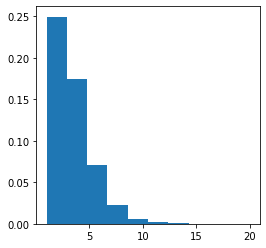

In [56]:
title_len = title_pipeline.transform(movies)["Title_Len"]

plt.figure(figsize=(4,4))
plt.hist(title_len, bins=10, density=True)

plt.show()

5. Procent filmów zawierających cyfry / dwukropki / myślniki

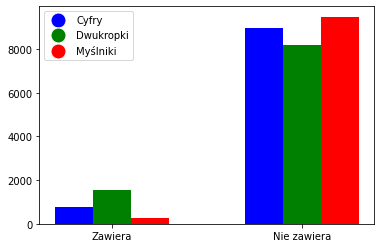

In [120]:
from matplotlib.lines import Line2D

titles_data = title_pipeline.transform(movies)

titles_has_numbers = titles_data["Title_Numbers"].sum()
titles_has_no_numbers = len(titles_data["Title_Numbers"]) - titles_has_numbers

titles_has_colon = titles_data["Title_Colon"].sum()
titles_has_no_colon = len(titles_data["Title_Colon"]) - titles_has_colon

titles_has_dash = titles_data["Title_Dash"].sum()
titles_has_no_dash = len(titles_data["Title_Dash"]) - titles_has_dash

labels = ["Zawiera", "Nie zawiera"]
x = np.arange(len(labels))

titles_numbers = [titles_has_numbers, titles_has_no_numbers]
titles_colons = [titles_has_colon, titles_has_no_colon]
titles_dashes = [titles_has_dash, titles_has_no_dash]

ax = plt.subplot(111)
ax.bar(x - 0.2, titles_numbers, width=0.2, color='b', align='center')
ax.bar(x, titles_colons, width=0.2, color='g', align='center', tick_label=labels)
ax.bar(x+0.2, titles_dashes, width=0.2, color='r', align='center')

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Cyfry', markerfacecolor='b', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Dwukropki', markerfacecolor='g', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Myślniki', markerfacecolor='r', markersize=15),
]
ax.legend(handles=custom_legend)

plt.show()

**MODELE**

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


1. ElasticNet

In [194]:
from sklearn.linear_model import ElasticNet

ElasticNet_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", ElasticNet())
])

ElasticNet_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

grid_1 = GridSearchCV(estimator=ElasticNet_pipeline,
                      param_grid=ElasticNet_param_grid, scoring="r2", cv=kFold)
grid_1.fit(X_train, y_train)
grid_1.best_params_


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.134e+01, tolerance: 6.013e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.062e-01, tolerance: 6.053e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

{'regressor__alpha': 0.001, 'scaler': None}

2. SVR RBF

In [ ]:
from sklearn.svm import SVR

SVR_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", StandardScaler()),
    ("regressor", SVR(kernel="rbf"))
])

SVR_param_grid = {
    "regressor__C": [0.01, 0.1, 1, 10, 100, 1000],
    "regressor__gamma": [0.001, 0.01, 0.1, 1],
}

grid_2 = GridSearchCV(estimator=SVR_pipeline,
                      param_grid=SVR_param_grid, scoring="r2", cv=kFold)
grid_2.fit(X_train, y_train)
grid_2.best_params_


{'regressor__C': 1, 'regressor__gamma': 0.01}

3. Drzewo decyzyjne

In [ ]:
from sklearn.tree import DecisionTreeRegressor

DecisionTree_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", DecisionTreeRegressor())
])

DecisionTree_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__max_depth": [None, 1, 2, 3, 4, 5],
    "regressor__max_features": [None, "auto", "sqrt", "log2"],
    "regressor__criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
}

grid_3 = GridSearchCV(estimator=DecisionTree_pipeline,
                      param_grid=DecisionTree_param_grid, scoring="r2", cv=kFold)
grid_3.fit(X_train, y_train)
grid_3.best_params_


{'regressor__criterion': 'friedman_mse',
 'regressor__max_depth': 5,
 'regressor__max_features': None,
 'scaler': MinMaxScaler()}

4. Liniowy SVR

In [ ]:
from sklearn.svm import LinearSVR

LinearSVR_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", LinearSVR())
])

LinearSVR_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

grid_4 = GridSearchCV(estimator=LinearSVR_pipeline,
                      param_grid=LinearSVR_param_grid, scoring="r2", cv=kFold)
grid_4.fit(X_train, y_train)
grid_4.best_params_


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.w

{'regressor__C': 0.1, 'scaler': MinMaxScaler()}

5. Regresja Lasso

In [ ]:
from sklearn.linear_model import Lasso

Lasso_pipeline = Pipeline([
    ("preprocessing", preprocess_pipeline),
    ("scaler", None),
    ("regressor", Lasso())
])

Lasso_param_grid = {
    "scaler": [None, StandardScaler(), MinMaxScaler()],
    "regressor__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
}

grid_5 = GridSearchCV(estimator=Lasso_pipeline,
                      param_grid=Lasso_param_grid, scoring="r2", cv=kFold)
grid_5.fit(X_train, y_train)
grid_5.best_params_


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e+01, tolerance: 6.013e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e+02, tolerance: 6.025e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

{'regressor__alpha': 0.001, 'scaler': None}

**Porównanie płytkich modeli**

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, max_error

models = []

models.append(("ElasticNet", grid_1.best_score_, grid_1.best_estimator_))
models.append(("SVR", grid_2.best_score_, grid_2.best_estimator_))
models.append(("Decision Tree", grid_3.best_score_, grid_3.best_estimator_))
models.append(("Linear SVR", grid_4.best_score_, grid_4.best_estimator_))
models.append(("Lasso", grid_5.best_score_, grid_5.best_estimator_))

names = []
scores_train = []
scores_test_r2 = []
scores_test_mse = []
scores_test_me = []

for name, train_score, estimator in models:
    names.append(name)
    scores_train.append(train_score)

    r2_test_score = r2_score(y_test, estimator.predict(X_test))
    scores_test_r2.append(r2_test_score)

    mse_test_score = mean_squared_error(y_test, estimator.predict(X_test))
    scores_test_mse.append(mse_test_score)

    me_test_score = max_error(y_test, estimator.predict(X_test))
    scores_test_me.append(me_test_score)


model_data = {
    "model name": names,
    "training score (r2)": scores_train,
    "test score (r2)": scores_test_r2,
    "test score (mean squared error)": scores_test_mse,
    "test score (max error)": scores_test_me
}
table = pd.DataFrame(model_data)
table


,model name,training score (r2),test score (r2),test score (mean squared error),test score (max error)
0,ElasticNet,0.197765,0.206276,0.659564,4.374816
1,SVR,0.229291,0.245390,0.627062,4.841273
2,Decision Tree,0.177988,0.174545,0.685932,4.215801
3,Linear SVR,0.190244,0.197078,0.667208,4.436693
4,Lasso,0.197216,0.204051,0.661413,4.375000


**Modele głębokie**

In [ ]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [ ]:
X_train_preprocessed = preprocess_pipeline.transform(X_train)
X_test_preprocessed = preprocess_pipeline.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train_preprocessed)

X_train_keras = scaler.transform(X_train_preprocessed)
X_test_keras = scaler.transform(X_test_preprocessed)

print(X_train_keras.shape)
print(X_test_keras.shape)


(8754, 66)
(973, 66)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout

from keras.callbacks import History

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from keras import backend as K


def keras_r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping_grid_search = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

In [ ]:
def build_model(n_hidden=1, n_neurons=30, activation="relu", dropout=None, batch_normalization=False, learning_rate=3e-3, input_shape=[66,]):
    model = keras.models.Sequential()

    model.add(keras.layers.InputLayer(input_shape=input_shape))

    for layer in range(n_hidden):
        if dropout or batch_normalization:
          model.add(keras.layers.Dense(n_neurons))
        else:
          model.add(keras.layers.Dense(n_neurons, use_bias=False))
        
        if batch_normalization:
          model.add(keras.layers.BatchNormalization())
        
        model.add(keras.layers.Activation(activation))

        if dropout:
          model.add(keras.layers.Dropout(dropout))

    
    model.add(keras.layers.Dense(1, activation="relu"))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[keras_r2])

    return model

In [ ]:
keras_class = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


1. Karas Randomized Search CV (liczba warstw + liczba neuronów)

In [ ]:
param_distribs_1 = {
    "n_hidden": [1, 2, 3, 4, 5],
    "n_neurons": np.arange(1, 100),
}

rnd_search_cv_1 = RandomizedSearchCV(keras_class, param_distribs_1, n_iter=30, cv=kFold, verbose=2, scoring="r2")
rnd_search_cv_1.fit(X_train_keras, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_grid_search])
rnd_search_cv_1.best_params_

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
176/176 [==============================] - 0s 2ms/step - loss: 72.5646 - keras_r2: 0.1158 - val_loss: 125.8454 - val_keras_r2: -0.5337
Epoch 19/100
176/176 [==============================] - 0s 2ms/step - loss: 73.1342 - keras_r2: 0.0494 - val_loss: 112.8989 - val_keras_r2: -0.4047
Epoch 20/100
176/176 [==============================] - 0s 2ms/step - loss: 73.2118 - keras_r2: 0.1115 - val_loss: 78.1986 - val_keras_r2: 0.0730
Epoch 21/100
176/176 [==============================] - 0s 2ms/step - loss: 72.3083 - keras_r2: 0.0812 - val_loss: 77.5881 - val_keras_r2: 0.0905
Epoch 22/100
176/176 [==============================] - 0s 2ms/step - loss: 72.8234 - keras_r2: -0.0014 - val_loss: 76.2159 - val_keras_r2: 0.1047
Epoch 23/100
176/176 [==============================] - 0s 2ms/step - loss: 72.4278 - keras_r2: 0.1138 - val_loss: 86.3537 - val_keras_r2: -0.0222
Epoch 24/100
176/176 [==============================] - 0s 2ms/ste

{'n_hidden': 3, 'n_neurons': 22}

In [ ]:
history = History()

model_1 = Sequential()
model_1.add(keras.layers.InputLayer(input_shape=X_train_keras.shape[1],))
model_1.add(Dense(22,activation="relu"))
model_1.add(Dense(22,activation="relu"))
model_1.add(Dense(22,activation="relu"))
model_1.add(Dense(1,activation="relu"))
model_1.summary()

model_1.compile(loss="mean_squared_error",optimizer="sgd", metrics=[keras_r2])

Model: "sequential_707"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2886 (Dense)          (None, 22)                1474      
                                                                 
 dense_2887 (Dense)          (None, 22)                506       
                                                                 
 dense_2888 (Dense)          (None, 22)                506       
                                                                 
 dense_2889 (Dense)          (None, 1)                 23        
                                                                 
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_1 = model_1.fit(X_train_keras, y_train, validation_data=(
    X_test_keras, y_test), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
])

Epoch 1/100
274/274 [==============================] - 1s 3ms/step - loss: 7.2033 - keras_r2: -8.9703 - val_loss: 0.9794 - val_keras_r2: -0.2785
Epoch 2/100
274/274 [==============================] - 1s 2ms/step - loss: 0.8114 - keras_r2: 0.0172 - val_loss: 0.6666 - val_keras_r2: 0.1708
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 0.7106 - keras_r2: 0.1467 - val_loss: 0.6782 - val_keras_r2: 0.1682
Epoch 4/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6861 - keras_r2: 0.1680 - val_loss: 0.6407 - val_keras_r2: 0.2085
Epoch 5/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6733 - keras_r2: 0.1887 - val_loss: 0.6989 - val_keras_r2: 0.1087
Epoch 6/100
274/274 [==============================] - 0s 2ms/step - loss: 0.6646 - keras_r2: 0.2008 - val_loss: 0.6313 - val_keras_r2: 0.2176
Epoch 7/100
274/274 [==============================] - 0s 2ms/step - loss: 0.6587 - keras_r2: 0.2122 - val_loss: 0.6340 - val_keras_r2: 0.21

In [ ]:
model_1.evaluate(X_test_keras, y_test)

31/31 [==============================] - 0s 1ms/step - loss: 0.6300 - keras_r2: 0.2011


[0.6300487518310547, 0.20114926993846893]

In [ ]:
history_1.history.keys()

dict_keys(['loss', 'keras_r2', 'val_loss', 'val_keras_r2'])

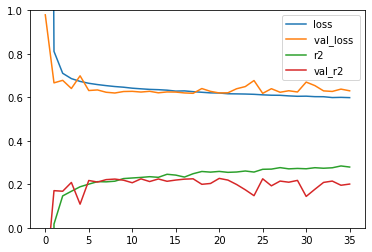

In [ ]:
plt.ylim(ymin=0, ymax=1)

plt.plot(history_1.history['loss'], label="loss")
plt.plot(history_1.history['val_loss'], label="val_loss ")

plt.plot(history_1.history['keras_r2'], label="r2")
plt.plot(history_1.history['val_keras_r2'], label="val_r2")

plt.legend()
plt.show()

2. Karas Randomized Search CV (liczba warstw + liczba neuronów + funkcja aktywacji)

In [ ]:
param_distribs_2 = {
    "n_hidden": [1, 2, 3, 4, 5],
    "n_neurons": np.arange(1, 100),
    "activation": ["relu", "elu", "sigmoid", "tanh"],
}

rnd_search_cv_2 = RandomizedSearchCV(keras_class, param_distribs_2, n_iter=10, cv=kFold, verbose=2, scoring="r2")
rnd_search_cv_2.fit(X_train_keras, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_grid_search])
rnd_search_cv_2.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/100
176/176 [==============================] - 1s 3ms/step - loss: 1933.4823 - keras_r2: -34.5009 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -25.1635 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -25.6227 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -28.3675 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -24.7708 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 1933.4823 - keras_r2: -25.0529 - val_loss: 1946.7059 - val_keras_r2: -24.9757
Epoch 7/100
176/176 [

{'activation': 'elu', 'n_hidden': 4, 'n_neurons': 23}

In [ ]:
history_2 = History()

model_2 = Sequential()
model_2.add(keras.layers.InputLayer(input_shape=X_train_keras.shape[1],))
model_2.add(Dense(23, activation="elu"))
model_2.add(Dense(23, activation="elu"))
model_2.add(Dense(23, activation="elu"))
model_2.add(Dense(23, activation="elu"))
model_2.add(Dense(1,activation="relu"))
model_2.summary()

model_2.compile(loss="mean_squared_error",optimizer="sgd", metrics=[keras_r2])

Model: "sequential_763"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3064 (Dense)          (None, 23)                1541      
                                                                 
 dense_3065 (Dense)          (None, 23)                552       
                                                                 
 dense_3066 (Dense)          (None, 23)                552       
                                                                 
 dense_3067 (Dense)          (None, 23)                552       
                                                                 
 dense_3068 (Dense)          (None, 1)                 24        
                                                                 
Total params: 3,221
Trainable params: 3,221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_2 = model_2.fit(X_train_keras, y_train, validation_data=(
    X_test_keras, y_test), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])

Epoch 1/100
274/274 [==============================] - 13s 2ms/step - loss: 1.5066 - keras_r2: -0.8833 - val_loss: 0.6891 - val_keras_r2: 0.1427
Epoch 2/100
274/274 [==============================] - 0s 2ms/step - loss: 0.7111 - keras_r2: 0.1444 - val_loss: 0.6745 - val_keras_r2: 0.1627
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6959 - keras_r2: 0.1697 - val_loss: 0.6860 - val_keras_r2: 0.1397
Epoch 4/100
274/274 [==============================] - 0s 2ms/step - loss: 0.6885 - keras_r2: 0.1726 - val_loss: 0.6624 - val_keras_r2: 0.1815
Epoch 5/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6859 - keras_r2: 0.1758 - val_loss: 0.6638 - val_keras_r2: 0.1769
Epoch 6/100
274/274 [==============================] - 0s 2ms/step - loss: 0.6785 - keras_r2: 0.1766 - val_loss: 0.6706 - val_keras_r2: 0.1708
Epoch 7/100
274/274 [==============================] - 1s 2ms/step - loss: 0.6757 - keras_r2: 0.1851 - val_loss: 0.6560 - val_keras_r2: 0.18

In [ ]:
model_2.evaluate(X_test_keras, y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.6329 - keras_r2: 0.1994


[0.632935643196106, 0.19943352043628693]

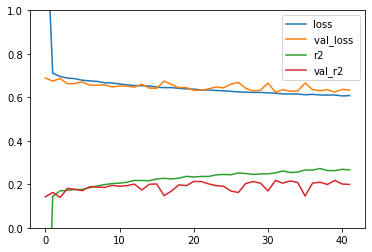

In [ ]:
plt.ylim(ymin=0, ymax=1)

plt.plot(history_2.history['loss'], label="loss")
plt.plot(history_2.history['val_loss'], label="val_loss ")

plt.plot(history_2.history['keras_r2'], label="r2")
plt.plot(history_2.history['val_keras_r2'], label="val_r2")

plt.legend()
plt.show()

3. Karas Randomized Search CV (liczba warstw + liczba neuronów + funkcja aktywacji + normalizacja + dropout)



In [ ]:
param_distribs_3 = {
    "n_hidden": [1, 2, 3, 4, 5],
    "n_neurons": np.arange(1, 100),
    "activation": ["relu", "elu", "sigmoid", "tanh"],
    "dropout": [0.1, 0.2, 0.3],
    "batch_normalization": [True, False],
}

rnd_search_cv_3 = RandomizedSearchCV(keras_class, param_distribs_3, n_iter=10, cv=kFold, verbose=2, scoring="r2")
rnd_search_cv_3.fit(X_train_keras, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_grid_search])
rnd_search_cv_3.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/100
176/176 [==============================] - 3s 6ms/step - loss: 237.2287 - keras_r2: -4.2866 - val_loss: 76.7985 - val_keras_r2: 0.0996
Epoch 2/100
176/176 [==============================] - 1s 5ms/step - loss: 125.2039 - keras_r2: -0.6041 - val_loss: 79.5292 - val_keras_r2: 0.0684
Epoch 3/100
176/176 [==============================] - 1s 4ms/step - loss: 113.9511 - keras_r2: -0.6522 - val_loss: 74.5797 - val_keras_r2: 0.1288
Epoch 4/100
176/176 [==============================] - 1s 4ms/step - loss: 109.3372 - keras_r2: -0.4478 - val_loss: 74.7149 - val_keras_r2: 0.1252
Epoch 5/100
176/176 [==============================] - 1s 5ms/step - loss: 104.2877 - keras_r2: -0.4131 - val_loss: 81.2418 - val_keras_r2: 0.0253
Epoch 6/100
176/176 [==============================] - 1s 5ms/step - loss: 97.8899 - keras_r2: -0.2290 - val_loss: 77.3570 - val_keras_r2: 0.0796
Epoch 7/100
176/176 [==============================] - 1s 

{'activation': 'elu',
 'batch_normalization': True,
 'dropout': 0.2,
 'n_hidden': 2,
 'n_neurons': 9}

In [ ]:
history_3 = History()

model_3 = Sequential()
model_3.add(keras.layers.InputLayer(input_shape=X_train_keras.shape[1],))
model_3.add(Dense(9, use_bias=False))
model_3.add(BatchNormalization())
model_3.add(Activation("elu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(9, use_bias=False))
model_3.add(BatchNormalization())
model_3.add(Activation("elu"))
model_3.add(Dropout(0.2))
model_3.add(Dense(1,activation="relu"))
model_3.summary()

model_3.compile(loss="mean_squared_error",optimizer="sgd", metrics=[keras_r2])

Model: "sequential_762"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3061 (Dense)          (None, 9)                 594       
                                                                 
 batch_normalization_69 (Bat  (None, 9)                36        
 chNormalization)                                                
                                                                 
 activation_764 (Activation)  (None, 9)                0         
                                                                 
 dropout_109 (Dropout)       (None, 9)                 0         
                                                                 
 dense_3062 (Dense)          (None, 9)                 81        
                                                                 
 batch_normalization_70 (Bat  (None, 9)                36        
 chNormalization)                                   

In [ ]:
# history_3 = model_3.fit(X_train_keras, y_train, validation_data=(
#     X_test_keras, y_test), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)])
history_3 = model_3.fit(X_train_keras, y_train, validation_data=(
    X_test_keras, y_test), batch_size=32, epochs=1000)

Epoch 1/1000
274/274 [==============================] - 2s 6ms/step - loss: 0.6745 - keras_r2: 0.1895 - val_loss: 0.6173 - val_keras_r2: 0.2383
Epoch 2/1000
274/274 [==============================] - 1s 4ms/step - loss: 0.6736 - keras_r2: 0.1899 - val_loss: 0.6134 - val_keras_r2: 0.2417
Epoch 3/1000
274/274 [==============================] - 1s 3ms/step - loss: 0.6730 - keras_r2: 0.1927 - val_loss: 0.6185 - val_keras_r2: 0.2374
Epoch 4/1000
274/274 [==============================] - 1s 3ms/step - loss: 0.6751 - keras_r2: 0.1981 - val_loss: 0.6166 - val_keras_r2: 0.2378
Epoch 5/1000
274/274 [==============================] - 1s 3ms/step - loss: 0.6735 - keras_r2: 0.1970 - val_loss: 0.6128 - val_keras_r2: 0.2415
Epoch 6/1000
274/274 [==============================] - 1s 2ms/step - loss: 0.6720 - keras_r2: 0.1901 - val_loss: 0.6170 - val_keras_r2: 0.2389
Epoch 7/1000
274/274 [==============================] - 1s 2ms/step - loss: 0.6728 - keras_r2: 0.1891 - val_loss: 0.6165 - val_keras_r2:

In [ ]:
model_3.evaluate(X_test_keras, y_test)

31/31 [==============================] - 0s 1ms/step - loss: 0.5979 - keras_r2: 0.2552


[0.5979011058807373, 0.25517895817756653]

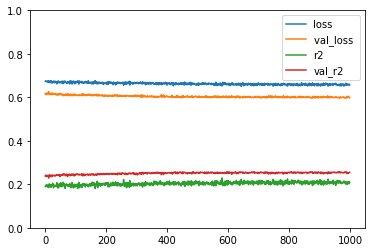

In [ ]:
plt.ylim(ymin=0, ymax=1)

plt.plot(history_3.history['loss'], label="loss")
plt.plot(history_3.history['val_loss'], label="val_loss ")

plt.plot(history_3.history['keras_r2'], label="r2")
plt.plot(history_3.history['val_keras_r2'], label="val_r2")

plt.legend()
plt.show()

**Porównanie modeli głębokich**

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, max_error

models = []

models.append(("Podstawowa", model_1))
models.append(("Podstawowa z dobraną funkcją aktywacji", model_2))
models.append(("Z Batch Normalization i Dropout", model_3))

names = []
scores_test_r2 = []
scores_test_mse = []
scores_test_me = []

for name, estimator in models:
    names.append(name)

    r2_test_score = r2_score(y_test, estimator.predict(X_test_keras))
    scores_test_r2.append(r2_test_score)

    mse_test_score = mean_squared_error(y_test, estimator.predict(X_test_keras))
    scores_test_mse.append(mse_test_score)

    me_test_score = max_error(y_test, estimator.predict(X_test_keras))
    scores_test_me.append(me_test_score)


model_data = {
    "model name": names,
    "test score (r2)": scores_test_r2,
    "test score (mean squared error)": scores_test_mse,
    "test score (max error)": scores_test_me
}
table = pd.DataFrame(model_data)
table


,model name,test score (r2),test score (mean squared error),test score (max error)
0,Podstawowa,0.241795,0.630049,4.225017
1,Podstawowa z dobraną funkcją aktywacji,0.238321,0.632936,3.926939
2,Z Batch Normalization i Dropout,0.280482,0.597901,4.127440
